In [115]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score


# warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  #hide any pandas warnings

sns.set(style="whitegrid", color_codes=True)

In [92]:
# Define confusion matrix function
def do_confusion_matrix(Y, prediction):
    cm = confusion_matrix(Y, prediction)
    cm_df = pd.DataFrame(cm, index=["True", "False"], columns=["Positive", "Negative"])
    sns.heatmap(cm_df, annot=True, square=True, cmap="YlGnBu")
    plt.tight_layout()
    plt.show()
    print("Sensitivity (True Positives Rate):", np.round(cm[0,0]/(cm[0,0] + cm[1,1]), 2))
    print("Specificity (True Negatives Rate):", np.round(cm[0,1]/(cm[0,1] + cm[1,0]), 2))

In [93]:
# Read data
file_name = 'heart.csv'
ds = pd.read_csv(file_name)

# Drop rows with thal equal to 0
ds.drop(ds[ds['thal'] == 0].index, axis=0, inplace=True)

In [94]:

# Columns rename
ds.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

# Modifico i valori in modo da identificare con chiarezza le
# feature categoriche
ds['sex'][ds['sex'] == 0] = 'female'
ds['sex'][ds['sex'] == 1] = 'male'

ds['chest_pain_type'][ds['chest_pain_type'] == 0] = 'typical angina'
ds['chest_pain_type'][ds['chest_pain_type'] == 1] = 'atypical angina'
ds['chest_pain_type'][ds['chest_pain_type'] == 2] = 'non-anginal pain'
ds['chest_pain_type'][ds['chest_pain_type'] == 3] = 'asymptomatic'

ds['fasting_blood_sugar'][ds['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
ds['fasting_blood_sugar'][ds['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

ds['rest_ecg'][ds['rest_ecg'] == 0] = 'normal'
ds['rest_ecg'][ds['rest_ecg'] == 1] = 'ST-T wave abnormality'
ds['rest_ecg'][ds['rest_ecg'] == 2] = 'left ventricular hypertrophy'

ds['exercise_induced_angina'][ds['exercise_induced_angina'] == 0] = 'no'
ds['exercise_induced_angina'][ds['exercise_induced_angina'] == 1] = 'yes'

ds['st_slope'][ds['st_slope'] == 0] = 'upsloping'
ds['st_slope'][ds['st_slope'] == 1] = 'flat'
ds['st_slope'][ds['st_slope'] == 2] = 'downsloping'

ds['thalassemia'][ds['thalassemia'] == 1] = 'normal'
ds['thalassemia'][ds['thalassemia'] == 2] = 'fixed defect'
ds['thalassemia'][ds['thalassemia'] == 3] = 'reversable defect'


# Converto i tipi in modo corretto

ds['sex'] = ds['sex'].astype('object')
ds['chest_pain_type'] = ds['chest_pain_type'].astype('object')
ds['fasting_blood_sugar'] = ds['fasting_blood_sugar'].astype('object')
ds['rest_ecg'] = ds['rest_ecg'].astype('object')
ds['exercise_induced_angina'] = ds['exercise_induced_angina'].astype('object')
ds['st_slope'] = ds['st_slope'].astype('object')
ds['thalassemia'] = ds['thalassemia'].astype('object')

In [95]:
# Dataset sample
ds.sample(10)

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
163,38,male,non-anginal pain,138,175,lower than 120mg/ml,ST-T wave abnormality,173,no,0.0,downsloping,4,fixed defect,1
73,51,male,typical angina,140,261,lower than 120mg/ml,normal,186,yes,0.0,downsloping,0,fixed defect,1
105,68,female,non-anginal pain,120,211,lower than 120mg/ml,normal,115,no,1.5,flat,0,fixed defect,1
240,70,male,non-anginal pain,160,269,lower than 120mg/ml,ST-T wave abnormality,112,yes,2.9,flat,1,reversable defect,0
233,64,male,typical angina,120,246,lower than 120mg/ml,normal,96,yes,2.2,upsloping,1,fixed defect,0
173,58,male,non-anginal pain,132,224,lower than 120mg/ml,normal,173,no,3.2,downsloping,2,reversable defect,0
104,50,male,non-anginal pain,129,196,lower than 120mg/ml,ST-T wave abnormality,163,no,0.0,downsloping,0,fixed defect,1
150,66,male,typical angina,160,228,lower than 120mg/ml,normal,138,no,2.3,downsloping,0,normal,1
296,63,female,typical angina,124,197,lower than 120mg/ml,ST-T wave abnormality,136,yes,0.0,flat,0,fixed defect,0
113,43,male,typical angina,110,211,lower than 120mg/ml,ST-T wave abnormality,161,no,0.0,downsloping,0,reversable defect,1


In [96]:
# Shape of dataset
print("Rows:", ds.shape[0], "\nFeatures:", ds.shape[1])

Rows: 301 
Features: 14


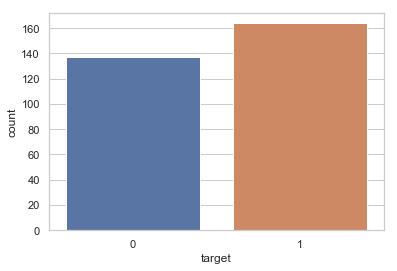

In [97]:
sns.countplot(x=ds['target'])
plt.show()

In [98]:
pd.set_option('display.max_columns', None)
ds.info()
ds.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 0 to 302
Data columns (total 14 columns):
age                        301 non-null int64
sex                        301 non-null object
chest_pain_type            301 non-null object
resting_blood_pressure     301 non-null int64
cholesterol                301 non-null int64
fasting_blood_sugar        301 non-null object
rest_ecg                   301 non-null object
max_heart_rate_achieved    301 non-null int64
exercise_induced_angina    301 non-null object
st_depression              301 non-null float64
st_slope                   301 non-null object
num_major_vessels          301 non-null int64
thalassemia                301 non-null object
target                     301 non-null int64
dtypes: float64(1), int64(6), object(7)
memory usage: 45.3+ KB


,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000
mean,54.378738,131.647841,246.504983,149.740864,1.043189,0.734219,0.544850
std,9.110950,17.594002,51.915998,22.891031,1.163384,1.024268,0.498814
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000
25%,47.000000,120.000000,211.000000,134.000000,0.000000,0.000000,0.000000
50%,56.000000,130.000000,241.000000,153.000000,0.800000,0.000000,1.000000
75%,61.000000,140.000000,275.000000,166.000000,1.600000,1.000000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,4.000000,1.000000


In [99]:
print("There are missing values?", ds.isnull().values.any())

There are missing values? False


In [100]:
# Dummy features
ds = pd.get_dummies(ds, drop_first=True)

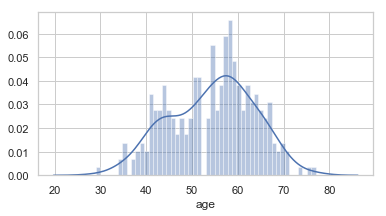

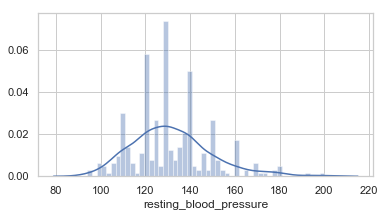

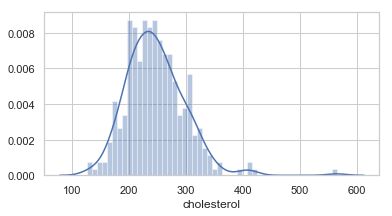

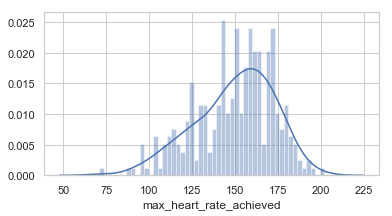

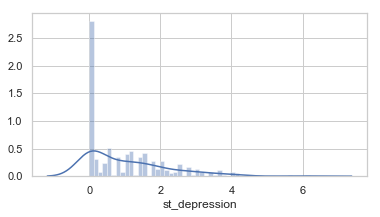

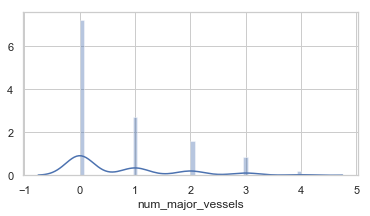

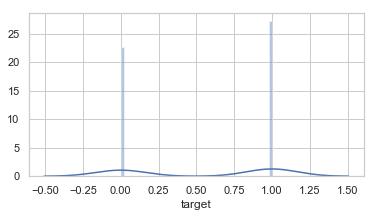

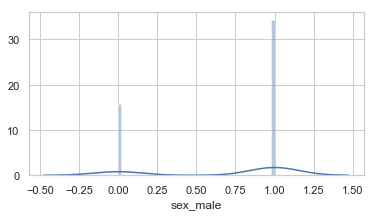

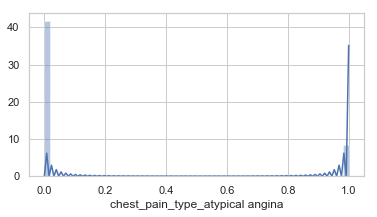

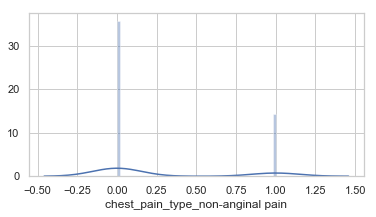

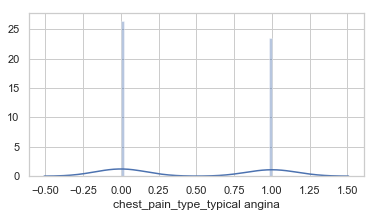

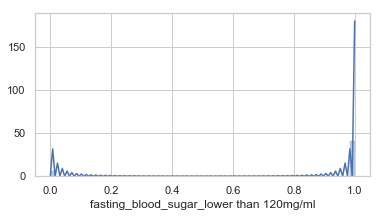

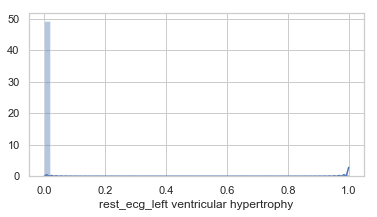

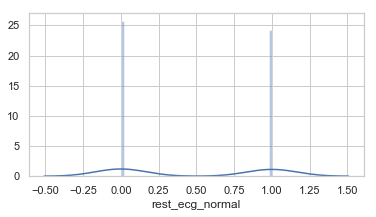

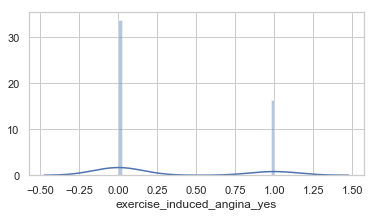

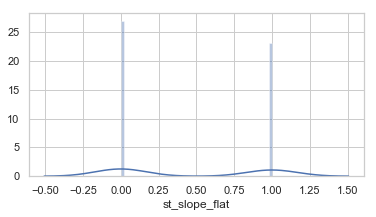

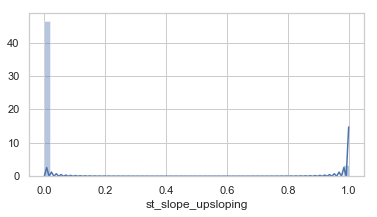

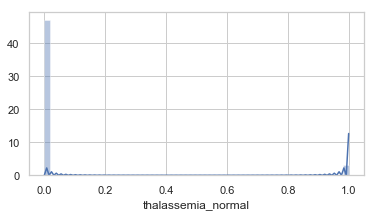

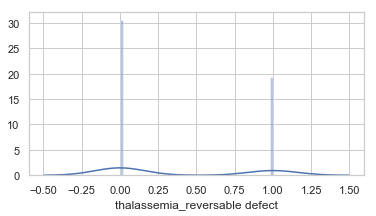

In [101]:
# Analisi sui dati

for c in ds.columns:
    plt.figure(figsize=(6, 3))
    sns.distplot(ds[c], hist=True, bins=50)
    plt.show()


In [102]:
# Split data in dataset and values to predict
X = ds.drop(['target'], axis=1) # X -> data
Y = ds['target'] # Y -> values to predict

In [103]:
#Uso RFC per estrarre le features più importanti

model = RandomForestClassifier(random_state = 50)

model.fit(X, Y)
feature_importance = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['RFC']).sort_values('RFC', ascending=False)
model = None
feature_importance.head(14)

,RFC
num_major_vessels,0.143354
max_heart_rate_achieved,0.124420
age,0.107511
st_depression,0.102255
chest_pain_type_typical angina,0.083805
thalassemia_reversable defect,0.080265
cholesterol,0.076838
exercise_induced_angina_yes,0.060197
resting_blood_pressure,0.052839
st_slope_flat,0.041635


In [104]:
# Normalizzo i dati
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
columns_names = X.columns
# Fit your data on the scaler object
X_scaled = X
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=columns_names)
X_scaled.describe()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_normal,thalassemia_reversable defect
count,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,301.000000,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02
mean,8.262125e-17,2.950759e-16,3.835987e-17,-9.442428e-17,0.000000,-2.360607e-17,-2.360607e-17,1.180304e-17,4.721214e-17,9.442428e-17,-1.209811e-16,2.065531e-17,-1.239319e-16,-7.081821e-17,-2.360607e-17,6.491670e-17,5.901518e-18,2.360607e-17
std,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00,1.001665e+00
min,-2.790159e+00,-2.143374e+00,-2.325019e+00,-3.445541e+00,-0.898179,-7.180170e-01,-1.472556e+00,-4.463218e-01,-6.324555e-01,-9.450300e-01,-2.416797e+00,-1.160518e-01,-9.705336e-01,-6.948083e-01,-9.262962e-01,-2.738613e-01,-2.521988e-01,-7.974143e-01
25%,-8.112244e-01,-6.631372e-01,-6.850318e-01,-6.887884e-01,-0.898179,-7.180170e-01,-1.472556e+00,-4.463218e-01,-6.324555e-01,-9.450300e-01,4.137707e-01,-1.160518e-01,-9.705336e-01,-6.948083e-01,-9.262962e-01,-2.738613e-01,-2.521988e-01,-7.974143e-01
50%,1.782429e-01,-9.381519e-02,-1.062129e-01,1.426132e-01,-0.209384,-7.180170e-01,6.790913e-01,-4.463218e-01,-6.324555e-01,-9.450300e-01,4.137707e-01,-1.160518e-01,-9.705336e-01,-6.948083e-01,-9.262962e-01,-2.738613e-01,-2.521988e-01,-7.974143e-01
75%,7.279470e-01,4.755068e-01,5.497818e-01,7.114670e-01,0.479410,2.599157e-01,6.790913e-01,-4.463218e-01,1.581139e+00,1.058167e+00,4.137707e-01,-1.160518e-01,1.030361e+00,1.439246e+00,1.079568e+00,-2.738613e-01,-2.521988e-01,1.254053e+00
max,2.487000e+00,3.891439e+00,6.125737e+00,2.286754e+00,4.439978,3.193714e+00,6.790913e-01,2.240536e+00,1.581139e+00,1.058167e+00,4.137707e-01,8.616844e+00,1.030361e+00,1.439246e+00,1.079568e+00,3.651484e+00,3.965126e+00,1.254053e+00


In [105]:
# Split train set and test set (train: 80% test: 20%)
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.2, random_state = 50)
print("Train set:", np.round(X_train.shape[0]/X.shape[0]*100), "%", "({}/{})".format(X_train.shape[0], X.shape[0]))
print("Test set:", np.round(X_test.shape[0]/X.shape[0]*100), "%", "({}/{})".format(X_test.shape[0], X.shape[0]))

Train set: 80.0 % (240/301)
Test set: 20.0 % (61/301)


The accuracy score on the testing set: 81.967 %


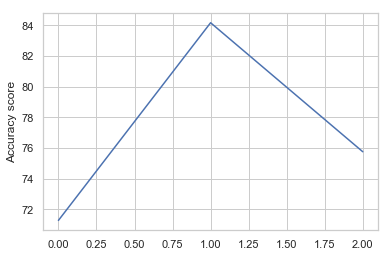

Accuracy CV: 77.06766666666665 %


In [106]:
# First attempt
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(random_state = 50)
model = model.fit(X_train, Y_train)
prediction = model.predict(X_test)
accuracy = accuracy_score(Y_test, prediction)
accuracy = np.round(accuracy * 100, 3)


print("The accuracy score on the testing set:", accuracy,"%")
#print("Hyperparameters values:\n", model.get_params())
model = None

from sklearn.model_selection import cross_val_score

model = RandomForestClassifier(random_state = 50)
#model = model.fit(X, Y_train)
accuracy = cross_val_score(model, X_scaled, Y, cv = 3, scoring = 'accuracy')
accuracy = np.round(accuracy * 100, 3)

model = None

plt.plot(accuracy, 'b', label="Training Acc")
plt.ylabel('Accuracy score')
plt.show()
print("Accuracy CV:", np.mean(accuracy), "%")

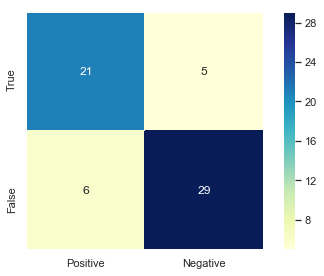

Sensitivity (True Positives Rate): 0.42
Specificity (True Negatives Rate): 0.45


In [107]:
do_confusion_matrix(Y_test, prediction)
    

### Hyperparameters tuning using Cross Validation


In [108]:
from sklearn.model_selection import validation_curve

def do_validation_curve(classifier, x, y, param_name, param_range):
    train_scores, test_scores = validation_curve(
                                    classifier,
                                    X=x, y=y, 
                                    param_name=param_name, 
                                    param_range=param_range,
                                    cv = 3)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 5))
    plt.title("Validation Curve with RFC")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.6, 1.1)
    lw = 1
    plt.plot(param_range, train_scores_mean,'.-', label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, '.-', label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

In [109]:
# Definisco le liste di iperparametri
# n_estimators max_depth min_samples_split min_samples_leaf max_features

max_features = list(range(1,X_scaled.shape[1]))
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 300, 500, 750]
min_samples_leaf = [1, 2, 4, 8]
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bootstrap = [False, True]

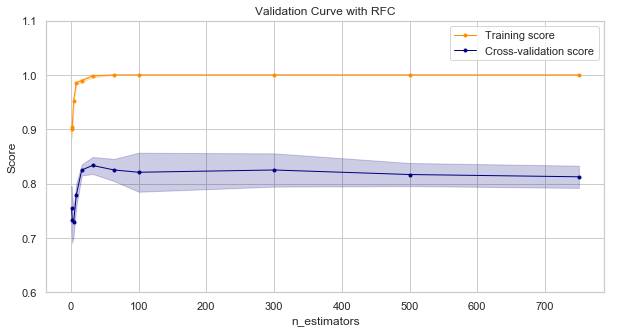

In [110]:
# Tuning n_estimators
do_validation_curve(RandomForestClassifier(), X_train, Y_train, 'n_estimators', n_estimators)

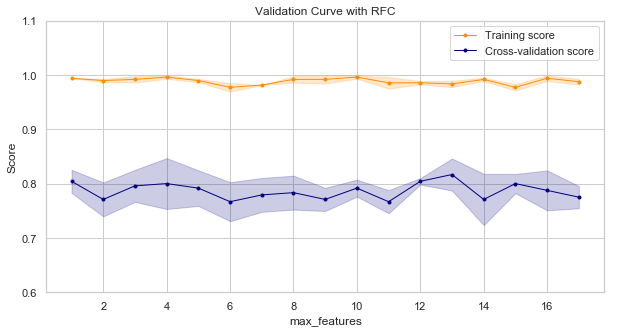

In [111]:
# Tuning max_features
do_validation_curve(RandomForestClassifier(), X_train, Y_train, 'max_features', max_features)

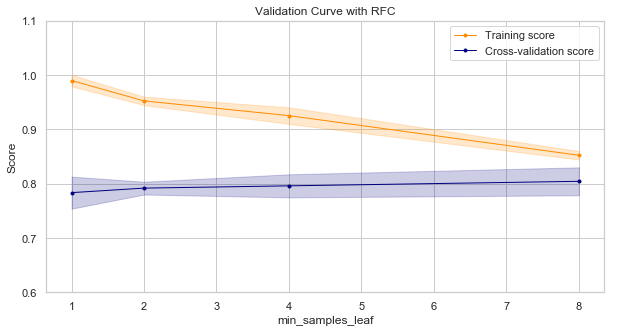

In [112]:
# Tuning min_samples_leaf
do_validation_curve(RandomForestClassifier(), X_train, Y_train, 'min_samples_leaf', min_samples_leaf)

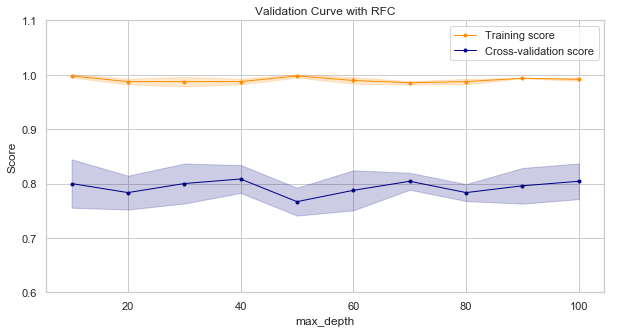

In [113]:
# Tuning max_depth
do_validation_curve(RandomForestClassifier(), X_train, Y_train, 'max_depth', max_depth)

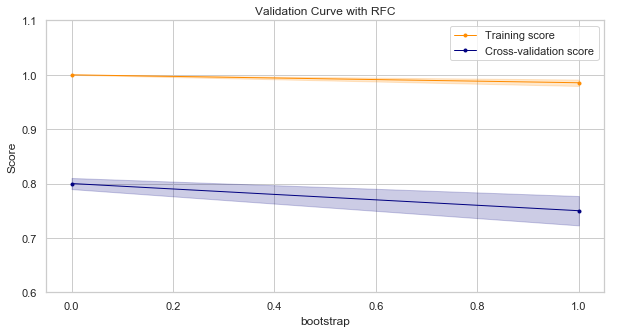

In [114]:
# Tuning bootstrap
do_validation_curve(RandomForestClassifier(), X_train, Y_train, 'bootstrap', bootstrap)

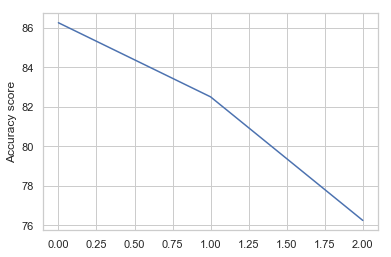

Cross Validation Accuracy Score: 81.66666666666667 %


In [151]:
# Cross Valdation Score
model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=70, random_state = 50)
accuracy = cross_val_score(model, X_train, Y_train, cv = 3, scoring = 'accuracy')
accuracy = np.round(accuracy * 100, 3)
model = None

plt.plot(accuracy, 'b', label="Training Acc")
plt.ylabel('Accuracy score')
plt.show()
print("Cross Validation Accuracy Score:", np.mean(accuracy), "%")

# Accuracy Score
model = RandomForestClassifier(n_estimators=100, random_state = 50)
model = model.fit(X_train, Y_train)
predict = model.predict(X_test)
accuracy = accuracy_score(Y_test, predict)
accuracy = np.round(accuracy * 100, 3)
model = None

print("The accuracy score on the testing set : ", accuracy,"%")

# Confusion Matrix
do_confusion_matrix(Y_test, prediction)

The accuracy score on the testing set :  83.607 %


## Confusion Matrix

## Hyperparameter tuning using Test Set

In [120]:
def do_test_set_hyperparameter_tuning(x_train, x_test, y_train, y_test, param_name, param_range):
    train_results = []
    test_results = []
    for param in param_range:
        model = RandomForestClassifier(**{param_name: param, 'random_state': 50})
        model.fit(x_train, y_train)

        # Train prediction
        train_pred = model.predict(x_train)
        accuracy = accuracy_score(y_train, train_pred)
        train_results.append(accuracy)

        # Test prediction
        test_pred = model.predict(x_test)
        accuracy = accuracy_score(y_test, test_pred)
        test_results.append(accuracy)
        model = None

    plt.figure(figsize=(10, 5))
    plt.title("Accuracy")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.6, 1.1)
    lw = 1
    plt.plot(param_range, train_results,'.-', label="Training score",
                 color="darkorange", lw=lw)
    plt.plot(param_range, test_results, '.-', label="Test score",
                 color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    print("Max Test Score:", np.round(np.max(test_results)*100, 3))
    print("Best Param Value:", param_range[np.argmax(test_results)])

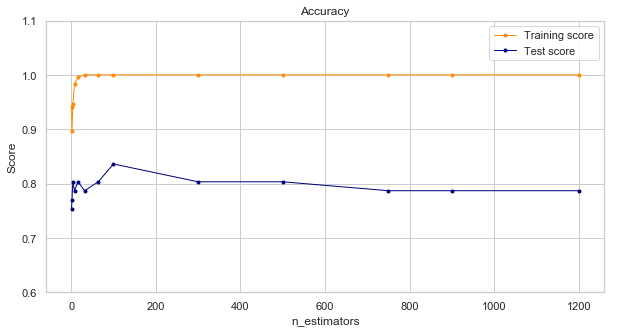

Max Test Score: 83.607
Best Param Value: 100


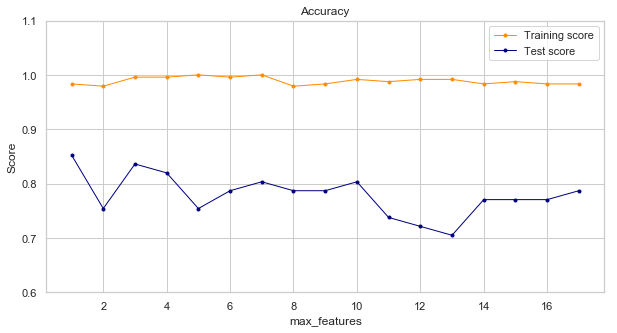

Max Test Score: 85.246
Best Param Value: 1


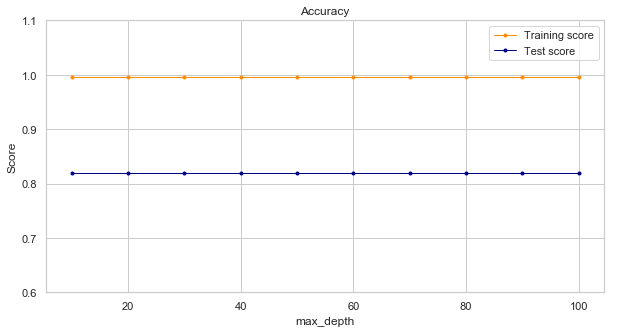

Max Test Score: 81.967
Best Param Value: 10


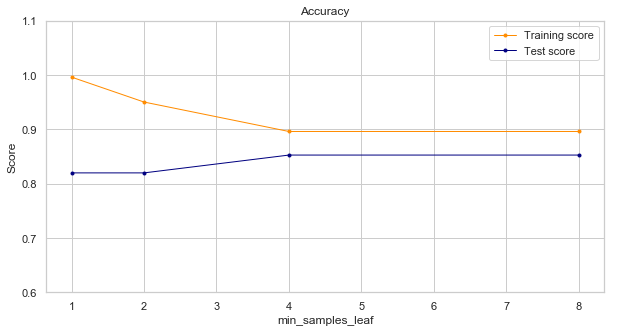

Max Test Score: 85.246
Best Param Value: 4


In [121]:
#max_features = list(range(1,X_scaled.shape[1]))
#n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 300, 500, 750, 900, 1200]
#min_samples_leaf = [1, 2, 4, 8]
#max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#bootstrap = [False, True]

do_test_set_hyperparameter_tuning(X_train, X_test, Y_train, Y_test, "n_estimators", n_estimators)
do_test_set_hyperparameter_tuning(X_train, X_test, Y_train, Y_test, "max_features", max_features)
do_test_set_hyperparameter_tuning(X_train, X_test, Y_train, Y_test, "max_depth", max_depth)
do_test_set_hyperparameter_tuning(X_train, X_test, Y_train, Y_test, "min_samples_leaf", min_samples_leaf)

In [149]:
model = RandomForestClassifier(random_state=50)
model.fit(X_train, Y_train)

# Test prediction
test_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, test_pred)
print("Accuracy:", np.round(accuracy*100, 3), "%")
model = None

Accuracy: 81.967 %


In [143]:
model = RandomForestClassifier(random_state=50, n_estimators=100, max_features=3, min_samples_leaf=4)
model.fit(X_train, Y_train)

# Test prediction
test_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, test_pred)
print("Accuracy:", np.round(accuracy*100, 3), "%")
model = None

Accuracy: 86.885 %


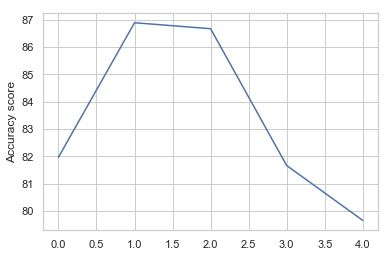

Accuracy CV: 83.36940000000001 %


In [153]:
model = RandomForestClassifier(random_state=50, n_estimators=100, max_features=3, min_samples_leaf=4)
accuracy = cross_val_score(model, X_scaled, Y, cv = 5, scoring = 'accuracy')
accuracy = np.round(accuracy * 100, 3)

model = None

plt.plot(accuracy, 'b', label="Training Acc")
plt.ylabel('Accuracy score')
plt.show()
print("Accuracy CV:", np.mean(accuracy), "%")

In [30]:
#max_features = list(range(1,X_scaled.shape[1]))
max_features = list(range(2,17))
n_estimators = [2, 4, 8, 16, 32, 64, 100, 300, 500]
accuracy_arr = np.zeros(len(max_features)*len(n_estimators))
tot = len(max_features)*len(n_estimators)*30
i = 0
# Itero k volte per ogni combinazione, ad ogni combinazione vengo quindi ad avere 5 misure, facendo la media delle 5
# ottengo un valore più preciso
for k in range(0,15):
    x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.2)
    j = -1
    for estimator in n_estimators:
        for max_f in max_features:
            j += 1
            model = RandomForestClassifier(n_estimators=estimator, max_features=max_f)
            model.fit(x_train, y_train)
            test_pred = model.predict(x_test)
            accuracy = accuracy_score(y_test, test_pred)
            accuracy_arr[j] = accuracy_arr[j] + accuracy/15
            model = None
            
            print("{}%".format(np.round(i/tot*100, 2)), end="\r")
            i += 1
            

    
            
print("Best accuracy:", accuracy_arr)
#print("Best n_estimators:", best_n_estimators_list)
#print("Best max_features:", best_max_features_list)
        
        

Best accuracy: [0.71256831 0.70273224 0.68196721 0.71256831 0.72131148 0.71256831
 0.72459016 0.70819672 0.71256831 0.69071038 0.72459016 0.73442623
 0.72786885 0.72459016 0.71803279 0.75409836 0.7715847  0.7726776
 0.7704918  0.76065574 0.78032787 0.77923497 0.7442623  0.74098361
 0.74754098 0.7715847  0.73333333 0.77377049 0.7704918  0.76393443
 0.80218579 0.79344262 0.79781421 0.78688525 0.78579235 0.79781421
 0.78142077 0.78251366 0.78688525 0.78907104 0.78142077 0.79453552
 0.78251366 0.8010929  0.79016393 0.80765027 0.80546448 0.81420765
 0.81202186 0.79562842 0.79672131 0.80546448 0.80655738 0.80327869
 0.80437158 0.80983607 0.79562842 0.80437158 0.79672131 0.79672131
 0.81967213 0.83606557 0.8273224  0.83387978 0.82513661 0.82185792
 0.81857923 0.81420765 0.81530055 0.81420765 0.81530055 0.81530055
 0.80765027 0.81311475 0.80765027 0.82622951 0.83825137 0.83825137
 0.8284153  0.82622951 0.81311475 0.8273224  0.81967213 0.82076503
 0.82295082 0.81748634 0.81530055 0.80874317 0.8

In [47]:
accuracy_best = 0
n_estimators_best = 0
max_features_best = 0

j = -1
for estimator in n_estimators:
    for max_f in max_features:
        j += 1
        if accuracy_arr[j] > accuracy_best:
            #print("qui")
            accuracy_best = accuracy_arr[j]
            n_estimators_best = estimator
            max_features_best = max_f
            

print("Best accuracy:", accuracy_best)
print("Best n_estimators:", n_estimators_best)
print("Best max_features:", max_features_best)

Best accuracy: 0.8437158469945354
Best n_estimators: 100
Best max_features: 3


In [50]:
model = RandomForestClassifier(n_estimators=100, max_features=3, random_state=50)
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
accuracy = accuracy_score(Y_test, prediction)
print("Accuracy:", np.round(accuracy*100, 3), "%")
model = None

Accuracy: 85.246 %


In [63]:
model = RandomForestClassifier(n_estimators=100, max_features=3, random_state=50)
accuracy = cross_val_score(model, X_train, Y_train, cv = 3, scoring = 'accuracy')
accuracy = np.mean(accuracy)
print("Accuracy:", np.round(accuracy*100, 3), "%")
model = None

Accuracy: 81.667 %


In [65]:
model = RandomForestClassifier(random_state=50)
accuracy = cross_val_score(model, X_train, Y_train, cv = 3, scoring = 'accuracy')
accuracy = np.mean(accuracy)
print("Accuracy:", np.round(accuracy*100, 3), "%")
model = None

Accuracy: 80.417 %
